In [5]:
from typing import Any
import numpy as np
from scipy.spatial import cKDTree, Voronoi, ConvexHull, voronoi_plot_2d
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd

def random_in_ellipse(lambdas:np.ndarray|list, size=None, mean_scale=False):
    lambdas = np.asarray(lambdas)
    d, = lambdas.shape
    shape = (1,) if size is None else tuple(np.ravel(size))
    x = np.random.normal(0, 1, size=(*shape, d))
    x = x / np.linalg.norm(x, axis=1)[:,None]
    x = x @ np.diag(lambdas)
    r = np.random.uniform(0, 1, size=shape)**0.5
    if mean_scale:
        r /= (d+1) / (d+2)
    x *= r[:,None]
    return x[0] if size is None else x


def categorical_to_one_hot(X_cat:np.ndarray, d:int|None=None):
    N = len(X_cat)
    assert np.all(np.isclose(X_cat, X_cat.astype(int))), X_cat
    X_cat = X_cat.astype(int)
    if len(X_cat.shape)==2 and X_cat.shape[-1]==1:
        X_cat = X_cat[:,0]
    d_ = d if d is not None else int(X_cat.max() + 1)
    Y = np.zeros((N, d_))
    Y[np.arange(N), X_cat.astype(int)] = 1
    return Y


hypervolume = lambda d: np.pi**(d/2) / scipy.special.gamma(1 + d/2)
hypersurface = lambda d: d * hypervolume(d)

def fuzzy_unitary_radius(d):
    '''
    Radius R of the fuzzy neighborhood in d dimensions
    that has the same total weight (number of elements) as the
    hard neighborhood of raidus 1 in d dimensions.
    '''
    integral = scipy.special.gamma(1 + (d-1)/2) * 2**(3*d/2 - 1) / np.sqrt(np.pi)
    R = integral ** (-1/d)
    return R

class NotEnoughNeighbors(Exception):
    pass


class EllipseNeighborhoods:

    def __init__(self, X:np.ndarray):
        self.X = X
        self.tree = cKDTree(X)

    def hard_ball(self, x:np.ndarray, radius:float, min_n=None):
        idx = self.tree.query_ball_point(x, r=radius, p=2)
        X, counts = np.unique(self.X[idx], axis=0, return_counts=True)
        weights = counts
        return self._ball(X, weights, min_n)

    def fuzzy_ball(self, x:np.ndarray, radius:float, alpha=0.95, min_n=None):
        d = len(x)
        radius *= fuzzy_unitary_radius(d)
        ref_dist = scipy.stats.chi(d)
        large_radius = ref_dist.ppf(alpha)
        idx = self.tree.query_ball_point(x, r=large_radius, p=2)
        X, counts = np.unique(self.X[idx], axis=0, return_counts=True)
        dists = np.linalg.norm(X-x, axis=1)
        probs = 1-ref_dist.cdf(dists / radius)
        weights = probs*counts
        return self._ball(X, weights, min_n)

    def _ball(self, X:np.ndarray, weights:np.ndarray, min_n=None):
        n_neigh = np.sum(weights)
        if len(X)<=1 or (min_n is not None and n_neigh < min_n):
            raise NotEnoughNeighbors
        mu = np.average(X, axis=0, weights=weights)
        cov = np.cov(X.T, aweights=weights)
        try:
            diag, V = np.linalg.eig(cov)
        except np.linalg.LinAlgError:
            raise NotEnoughNeighbors
        diag[np.isclose(diag,0, atol=1e-15)] = 0
        lambdas = np.sqrt(diag)
        if np.all(lambdas==0):
            raise NotEnoughNeighbors
        return n_neigh, mu, lambdas, V


from typing import Callable, Tuple


class ColumnGroup:
    scale = 1.0
    def __init__(self, scale=1.0):
        self.scale = scale

    @staticmethod
    def __pre_shape(X):
        X = np.asarray(X)
        assert len(X.shape) <= 2, X.shape
        shape = X.shape
        while len(X.shape) < 2:
            X = X[:,None]
        return X, shape
    
    def pre_post(self, X:np.ndarray) -> Tuple[np.ndarray, Callable[[np.ndarray], np.ndarray]]:
        raise NotImplementedError
    
    _Categorical:"type[ColumnGroupCategorical]"
    _Continuous:"type[ColumnGroupContinuous]"
    _Discrete:"type[ColumnGroupDiscrete]"
    List:"type[ColumnGroupList]"
    # For simplicity when creating the list:
    @classmethod
    def Cont(cls, idx:list[int]|int, scale=1.0):
        return (idx, cls._Continuous(scale=scale))
    @classmethod
    def Disc(cls, idx:list[int]|int, scale=1.0):
        return (idx, cls._Discrete(scale=scale))
    @classmethod
    def Cat(cls, idx:list[int]|int, scale=1.0, d:int|None=None):
        return (idx, cls._Categorical(scale=scale, d=d))


class ColumnGroupContinuous(ColumnGroup):
    def pre_post(self, X:np.ndarray):
        X, X_shape = self.__pre_shape(X)
        mu, sigma = X.mean(axis=0), X.std(axis=0)
        X = (X - mu) / (sigma * self.scale)

        def post(Y:np.ndarray):
            Y = Y * (sigma*self.scale) + mu
            return Y.reshape(X_shape)
        return X, post
    
class ColumnGroupDiscrete(ColumnGroup):
    def pre_post(self, X:np.ndarray):
        X, post_cont = ColumnGroupContinuous(scale=self.scale).pre_post(X) 
        uniques = np.unique(X, axis=0)
        tree = cKDTree(uniques)
        
        def post(Y:np.ndarray):
            _, idx = tree.query(Y, k=1)
            Y = uniques[idx]
            return post_cont(Y)
        
        return X, post

class ColumnGroupCategorical(ColumnGroup):

    def __init__(self, scale=1.0, d:int|None=None):
        self.scale = scale
        self.d = d
    
    def pre_post(self, X_cat:np.ndarray):
        X_cat, X_cat_shape = self.__pre_shape(X_cat)
        assert X_cat.shape[-1] == 1, X_cat.shape
        X = categorical_to_one_hot(X_cat[:,0], d=self.d)
        d = X.shape[1]
        # Read comparison-cat-cont-2.ipynb for details about scaling
        mu, sigma = 1/d, np.sqrt((d-1)/d)
        X = (X - mu) / (sigma*self.scale)
        
        def post( Y:np.ndarray):
            # Rescaling commented because the argmax is unaffected with it
            # mu, sigma = self.mu_sigma
            # Y = Y * sigma + mu
            return np.argmax(Y, axis=1).reshape(X_cat_shape)
        return X, post

ColumnGroup._Categorical = ColumnGroupCategorical
ColumnGroup._Continuous = ColumnGroupContinuous
ColumnGroup._Discrete = ColumnGroupDiscrete


class ColumnGroupList(list[Tuple[np.ndarray, ColumnGroup]]):

    def __init__(self, *groups:Tuple[list[int]|int, ColumnGroup]):
        self[:] = [(np.ravel(idx), col_type) for (idx, col_type) in groups]
        idx = np.concatenate([np.ravel(idx) for idx, _ in self])
        assert set(idx) == set(range(len(idx))), "The continuous, categorical and discrete indices must be unique and cover all columns"
        self.d = len(idx)

    def __repr__(self) -> str:
        return f"ColumnGroups{super().__repr__()}"
    
    def pre_post(self, X: np.ndarray):
        cls = ColumnGroup
        print(cls)
        print(vars(cls))
        X, X_shape = cls.__pre_shape(X)
        assert self.d == X.shape[1], (self.d, X.shape[1])
        X_groups = [(idx, col_type.pre_post(X[:,idx])) for idx, col_type in self]

        X_pre = np.concatenate([X_pre for _, (X_pre, _) in X_groups], axis=1)
        
        def post(Y:np.ndarray):
            out = np.ones_like(X) * np.nan
            i = 0
            for idx, (X_pre, post_) in X_groups:
                j = i+X_pre.shape[1]
                out[:, idx] = post_(Y[:, i:j])
                i = j
            assert i==Y.shape[1], (i, Y.shape[1])
            return out.reshape(X_shape)
        
        return X_pre, post

ColumnGroup.List = ColumnGroupList

class CG(ColumnGroup):
    pass

class EllipseNeighborhoodsMixedTypes(EllipseNeighborhoods):
    
    def __init__(self, X:np.ndarray, column_types:ColumnGroup.List):
        self.X = X
        self.tree = cKDTree(X)
        self.column_types = column_types

    def hard_ball(self, x: np.ndarray, radius: float, min_n=None):
        d = self.X.shape[1]
        # Pre filter
        taxicab_radius = radius * np.sqrt(d) # Smallest manhattan ball contains the euclidean distance
        idx = self.tree.query_ball_point(x, r=taxicab_radius, p=1)
        # Now filter the actual neighbors
        X = self.X[idx]
        dists = np.zeros(len(X))
        for idx, _ in self.column_types:
            dists += np.linalg.norm(X[:, idx] - x[idx], axis=1)
        X = X[dists <= radius]
        X, counts = np.unique(X, axis=0, return_counts=True)
        weights = counts
        return self._ball(X, weights, min_n)

    def fuzzy_ball(self, x:np.ndarray, radius:float, alpha=0.95, min_n=None):
        d = len(x)
        radius *= fuzzy_unitary_radius(d)
        ref_dist = scipy.stats.chi(d)
        large_radius = ref_dist.ppf(alpha) * np.sqrt(d)
        idx = self.tree.query_ball_point(x, r=large_radius, p=1)
        X = self.X[idx]
        X, counts = np.unique(X, axis=0, return_counts=True)
        dists = np.zeros(len(X))
        for idx, _ in self.column_types:
            dists += np.linalg.norm(X[:, idx] - x[idx], axis=1)
        probs = 1-ref_dist.cdf(dists / radius)
        weights = probs*counts
        return self._ball(X, weights, min_n)


min_neigh_radius = 0.2
min_neigh_count = 10
min_abs_noise_radius = 0
min_rel_noise_radius = 0
TEST = 1

def algorithm(X: np.ndarray, column_types:ColumnGroupList):
    global Xc, Yc
    X, post = column_types.pre_post(X)
    Xc = X.copy()
    N, d = X.shape
    Y = X * np.nan
    Yc = Y
    radii_that_work = []
    # Prepare nearest neighbor search
    neighs = EllipseNeighborhoodsMixedTypes(X, column_types)
    for i_x in tqdm(range(N)):
        xi = X[i_x]
        
        # Compute neighbors
        r = min_neigh_radius
        if i_x >= 10:
            r = max(r, float(np.quantile(radii_that_work, 0.2)))
        while True:
            try:
                neigh = neighs.fuzzy_ball(xi, r, min_n=min_neigh_count)
                break
            except NotEnoughNeighbors:
                r *= 1.1
        
        radii_that_work.append(r)
        _, x, lambdas, V = neigh
        min_noise_radius = max(min_abs_noise_radius, min_rel_noise_radius * r)
        y_lambdas = lambdas * max(1, min_noise_radius/float(np.linalg.norm(lambdas)))
        # Sample a random direction
        y = random_in_ellipse(y_lambdas)
        # y = np.random.normal(0, 1, d) * y_lambdas
        y = V @ y + x
        Y[i_x] = y
    Y = post(Y)
    return Y

np.random.seed(0)
X = np.random.normal(0, 1, (500,3))
X[:,0] = 2*X[:,0]
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.1 + np.sin(X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.1 - np.sin(X[mask,0])
column_types = CG.List(CG.Cont([0,1]), CG.Cat(2))
Y = algorithm(X, column_types)
print(np.mean(X[:,2]!=Y[:,2]))


for i_x in range(1):
    fig, axes = plt.subplots(1, 2, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[0].scatter(X[X[:,2]==0,0], X[X[:,2]==0,1], label='X|0', s=2)
    axes[0].scatter(X[X[:,2]==1,0], X[X[:,2]==1,1], label='X|1', s=2)
    axes[1].scatter(Y[Y[:,2]==0,0], Y[Y[:,2]==0,1], label='Y|0', s=2)
    axes[1].scatter(Y[Y[:,2]==1,0], Y[Y[:,2]==1,1], label='Y|1', s=2)
    axes[0].legend()
    axes[1].legend()
    # algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()


<class '__main__.ColumnGroup'>


AttributeError: type object 'ColumnGroup' has no attribute '_ColumnGroupList__pre_shape'

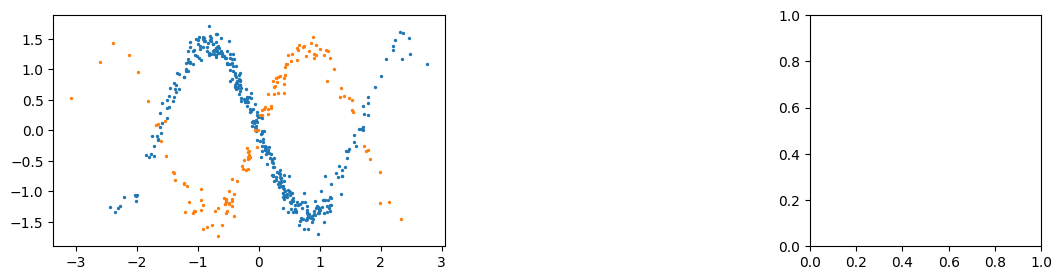

In [167]:

fig, axes = plt.subplots(1, 2, figsize=(16, 3))
axes = axes.flatten()
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[0].scatter(Xc[X[:,2]==0,0], Xc[X[:,2]==0,1], label='Xc|0', s=2)
axes[0].scatter(Xc[X[:,2]==1,0], Xc[X[:,2]==1,1], label='Xc|1', s=2)
plt.show()


In [168]:
Xc

array([[ 1.82267774, -0.46254869, -0.70710678,  0.70710678],
       [ 2.31340274,  1.6129766 ,  0.70710678, -0.70710678],
       [ 0.98501367, -1.32816722,  0.70710678, -0.70710678],
       ...,
       [-0.75442573,  1.30671527,  0.70710678, -0.70710678],
       [-2.21364334, -1.09150812,  0.70710678, -0.70710678],
       [-0.24671785,  0.51170097,  0.70710678, -0.70710678]])

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_26610/3041985158.py:80: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(X.T, aweights=weights)
100%|██████████| 500/500 [00:02<00:00, 217.90it/s]


0.15


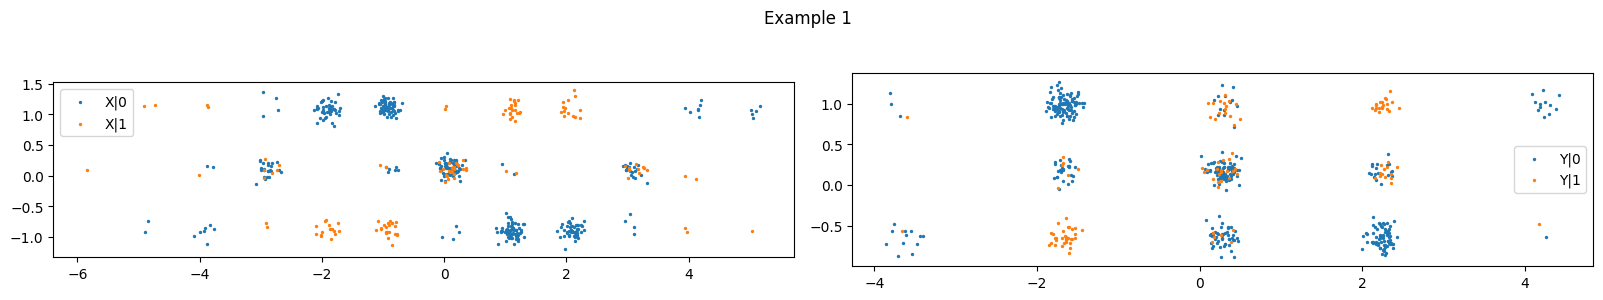

In [172]:

TEST=100
np.random.seed(0)
X = np.random.normal(0, 1, (500,3))
X[:,0] = 2*X[:,0]
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.1 + np.sin(X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.1 - np.sin(X[mask,0])
X = np.round(X)
X[:,:2] += 0.1
column_types = ColumnTypes(continuous=[], categorical=[2], discrete=[[0,1]])
Y = algorithm(X, column_types)
print(np.mean(X[:,2]!=Y[:,2]))

for i_x in range(1):
    fig, axes = plt.subplots(1, 2, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    noisy = lambda X: X+np.random.normal(0,1,X.shape)*1e-1
    axes[0].scatter(noisy(X[X[:,2]==0,0]), noisy(X[X[:,2]==0,1]), label='X|0', s=2)
    axes[0].scatter(noisy(X[X[:,2]==1,0]), noisy(X[X[:,2]==1,1]), label='X|1', s=2)
    axes[1].scatter(noisy(Y[Y[:,2]==0,0]), noisy(Y[Y[:,2]==0,1]), label='Y|0', s=2)
    axes[1].scatter(noisy(Y[Y[:,2]==1,0]), noisy(Y[Y[:,2]==1,1]), label='Y|1', s=2)
    axes[0].legend()
    axes[1].legend()
    # algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()


In [170]:
Y

array([[ 2.25570683,  0.16972246,  1.        ],
       [ 4.22089487,  0.98694703,  0.        ],
       [ 2.25570683, -0.64750211,  0.        ],
       ...,
       [-1.67466923,  0.98694703,  0.        ],
       [-3.63985726, -0.64750211,  0.        ],
       [ 0.2905188 ,  0.16972246,  0.        ]])

In [ ]:


# Generate test data
import matplotlib.pyplot as plt

np.random.seed(0)
X = np.random.normal(0, 1, (500,2))
X[:,1] =  X[:,1] * 0.1 + np.sin(2*X[:,0])
X = (3*X).astype(int)

column_types = ColumnTypes(continuous=[], categorical=[], discrete=[[0,1]])
Y = algorithm(X, column_types)

plt.scatter(X[:,0], X[:,1], s=2)
plt.scatter(Y[:,0], Y[:,1], s=2)
plt.show()

In [2]:

np.random.seed(0)
X = np.random.normal(0, 1, (1000,2))
X[:,1] =  X[:,1] * 0.1 + np.sin(2*X[:,0])
X = (2*X).astype(int).astype(float)
X[:,1] *= 0.37


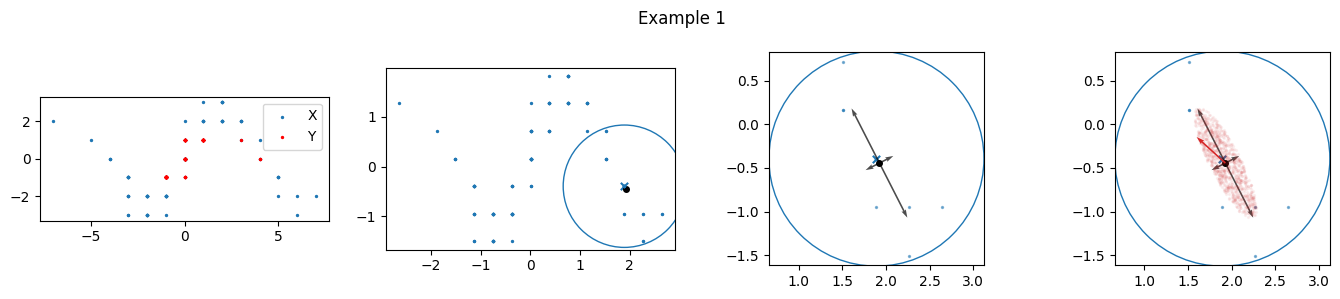

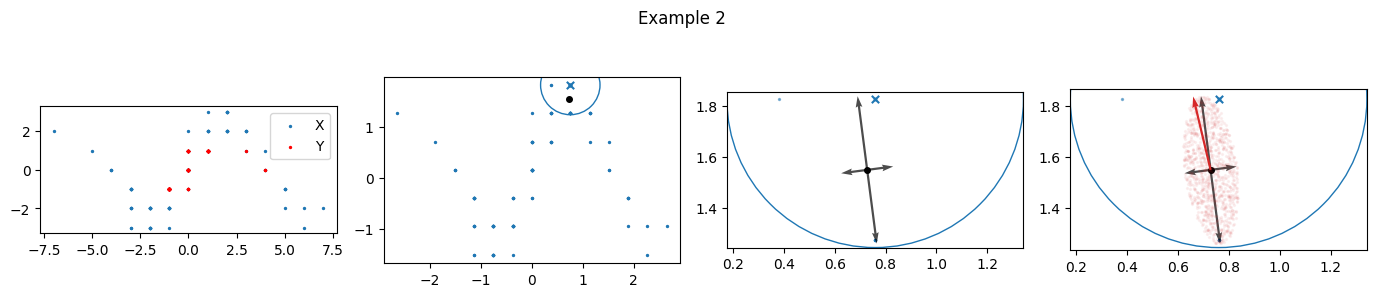

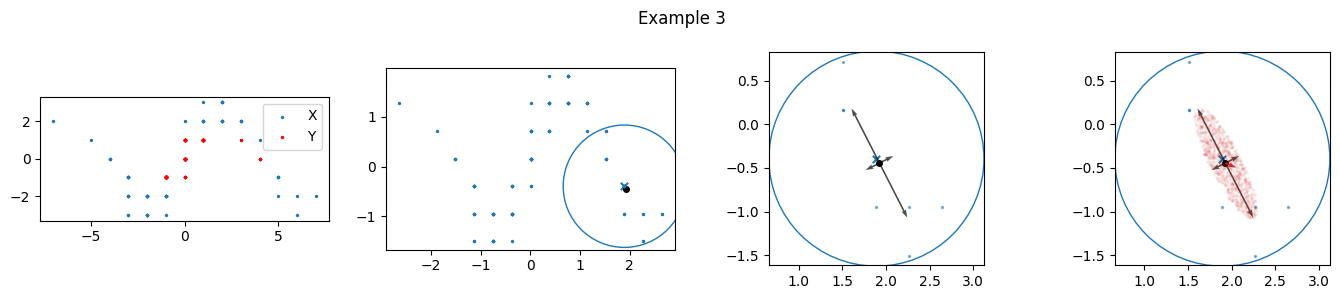

In [17]:



def algorithm_plot(X: np.ndarray, i_x=None, axes=None):
    X = np.asarray(X).astype(float)
    tree = cKDTree(X)
    N, d = X.shape
    assert d==2
    if i_x is None:
        i_x = np.random.randint(N)
    xi = X[i_x]
    # _, idx = tree.query(xi, k=N_explore, p=2)
    r = min_neigh_radius
    idx = tree.query_ball_point(xi, r=r, p=2)
    while len(idx) < min_neigh_count:
        r *= 1.1
        idx = tree.query_ball_point(xi, r=r, p=2)
    # print(r)
    x = X[idx].mean(axis=0)
    Nx = X[idx] - x
    # Diagonalize covariance matrix
    cov = np.cov(Nx.T)
    diag, V = np.linalg.eig(cov)
    lambdas = np.sqrt(diag)
    plot_radius = np.max(np.linalg.norm(Nx + x - xi, axis=1))* 1.05 
    plot_xlims = xi[0] + plot_radius* np.array([-1, 1])
    AxesType = plt.Axes # type:ignore
    def subset_plot(ax:"AxesType", show=[]):
        features = {k:True for k in show}
        ax.set_aspect('equal')
        if features.get('xi'):
            ax.scatter(xi[None,0], xi[None,1], marker='x', s=28, color='tab:blue')
        if features.get('x'):
            ax.scatter(x[None,0], x[None,1], marker='o', s=16, color='black')
        if features.get('X'):
            ax.scatter(X[:,0], X[:,1], label='X', s=2, color='tab:blue')
        if features.get('circle'):
            radius = np.max(np.linalg.norm(Nx + x - xi, axis=1))* 1.05
            circle = plt.Circle(xi, radius, fill=False, color='tab:blue') # type: ignore
            ax.add_artist(circle)
        if features.get('Nx'):
            ax.scatter(x[0]+Nx[:,0], x[1]+Nx[:,1], label='X', s=2, marker='o', color='tab:blue', alpha=0.5)
        # if features.get('Nxi'):
        #     ax.scatter(xi[0]+Nxi[:,0], xi[1]+Nxi[:,1], label='X', s=5, marker='o', color='tab:blue')
        if features.get('V'):
            for i_v in range(d):
                u = V[:, i_v] * lambdas[i_v]
                ax.quiver(*x, *u, scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
                ax.quiver(*x, *-u, scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
        if features.get('Y'):
            ax.scatter(Y[:,0], Y[:,1], s=2, c='tab:red', alpha=0.05) # For the plot limits 
            # xx = np.zeros_like(Y)
            # xx[:] = x[None,:]
            # ax.quiver(*xx.T, *(Y-x[None,:]).T, scale=1, scale_units='xy', color='tab:red', alpha=0.2)
        if features.get('Y_contour'):
            kw:Any = dict(fill=False, alpha=0.9, levels=5, linewidths=0.5)
            sns.kdeplot(data=pd.DataFrame(Y), x=0, y=1, ax=ax, color='tab:red', **kw)
        if features.get('y'):
            ax.quiver(*x, *(y-x),  scale=1, scale_units='xy', color='tab:red', alpha=1)
        if features.get('y_mean'):
            ax.quiver(*x, *(y_mean-x),  scale=1, scale_units='xy', color='tab:purple', alpha=1)
        return

    min_noise_radius = max(min_abs_noise_radius, min_rel_noise_radius * r)
    y_lambdas = lambdas * max(1, min_noise_radius/float(np.linalg.norm(lambdas)))
    y = random_in_ellipse(y_lambdas, mean_scale=True)
    y = V @ y + x

    # Do the sampling many times to show a contour plot
    N_samples = 1000
    Y = random_in_ellipse(y_lambdas, size=N_samples)
    Y =  (V @ Y.T).T + x[None, :]
    y_mean = np.mean(Y, axis=0)

    if axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(5, 5))
        axes = axes.flatten()
    subset_plot(axes[0], show='X xi x circle Nx'.split())
    subset_plot(axes[1], show='xi x circle Nx V'.split())
    # axes[1].set_xlim(axes[0].get_xlim())
    axes[1].set_xlim(*plot_xlims)
    subset_plot(axes[2], show='xi x circle Nx V Y y'.split())
    axes[2].set_xlim(*plot_xlims)
    return


# Generate test data
import matplotlib.pyplot as plt

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
X[:,1] =  X[:,1] * 0.1 + np.sin(2*X[:,0])
X = (3*X).astype(int)

column_types = ColumnTypes(continuous=[], categorical=[], discrete=[[0,1]])
Xc, post = column_types.data_pre_post(X)
Y = algorithm(X, column_types)

for i_x in range(3):
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()


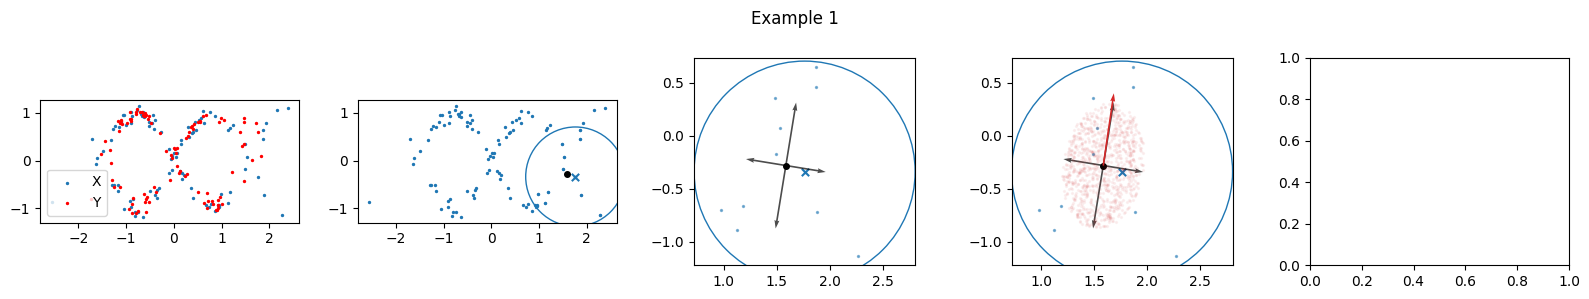

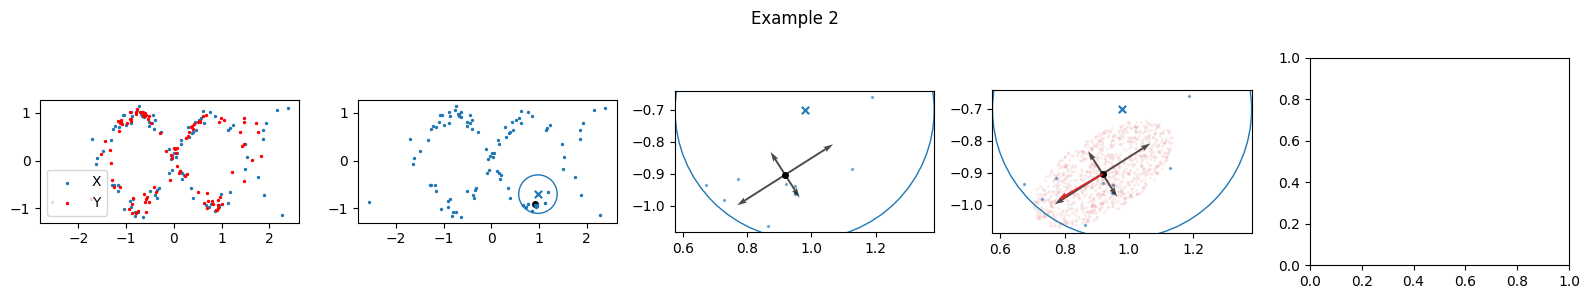

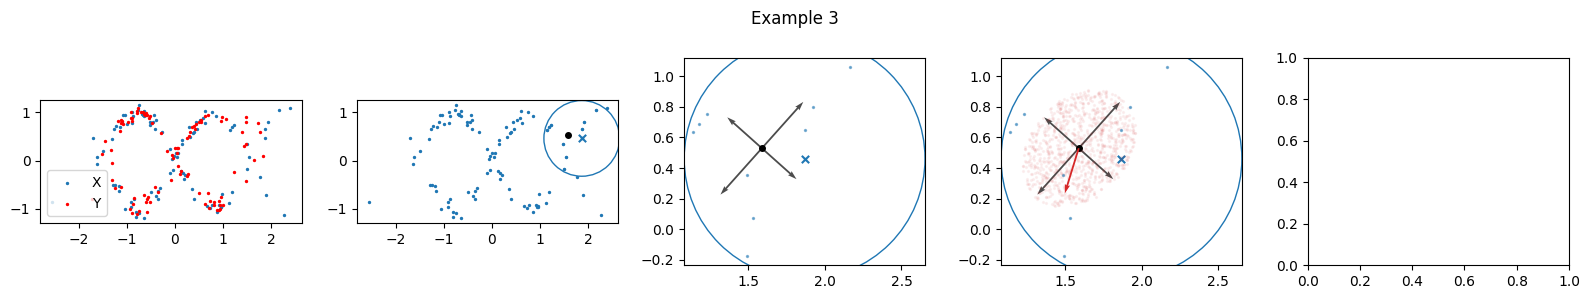

In [69]:

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
mask = np.random.rand(len(X)) > 0.5
X[mask,1] =  X[mask,1] * 0.1 + np.sin(2*X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.1 - np.sin(2*X[mask,0])
column_types = ColumnTypes(continuous=[0,1], categorical=[], discrete=[])
Xc, post = column_types.data_pre_post(X)
Yc = algorithm(Xc)
Y = post(Yc)

for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(Xc[:,0], Xc[:,1], label='X', s=2)
    axes[0].scatter(Yc[:,0], Yc[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()

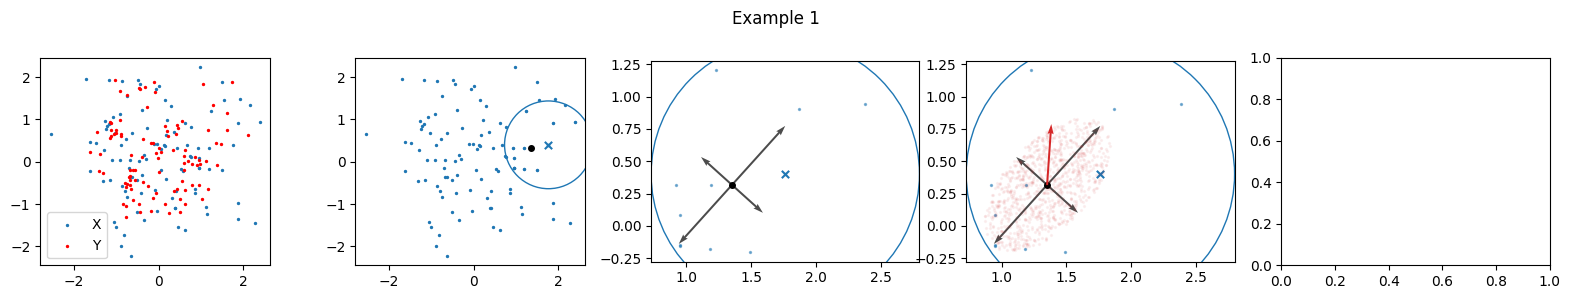

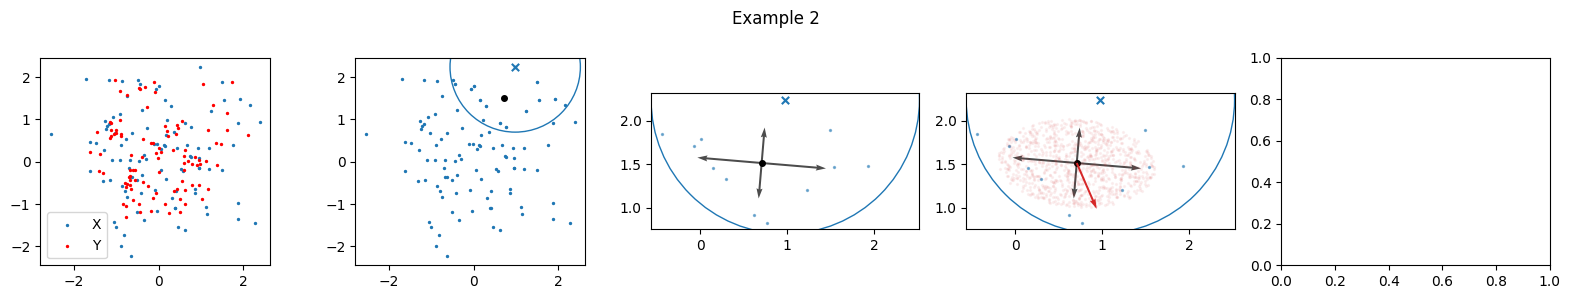

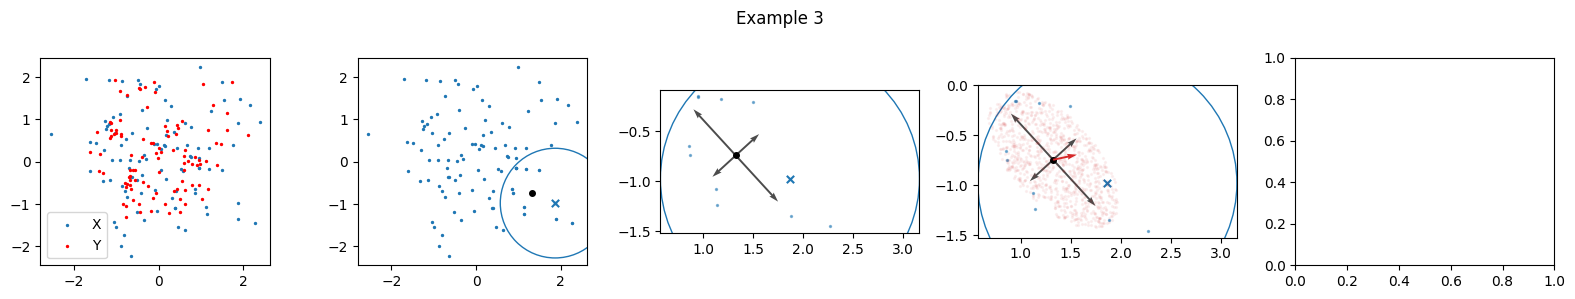

In [70]:

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
Y = algorithm(X)

for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(X, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()